<a href="https://colab.research.google.com/github/puzis/llmnet/blob/main/experiments/gpt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

In [1]:
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np

In [ ]:
#dataset = load_dataset("glue", "mrpc")
#inputs = dataset['train']['sentence1'][:15]
#dataset = load_dataset("Amod/mental_health_counseling_conversations")
#dataset = load_dataset("imdb")

In [ ]:
dataset = load_dataset("Amod/mental_health_counseling_conversations")
inputs = dataset['train']['Response'][:5]

In [ ]:
dataset = load_dataset("glue", "mrpc")
inputs = dataset['train']['sentence1'][:15]

In [2]:
dataset = load_dataset("imdb")
inputs = dataset['train']['text'][:5]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead
tokenizer = AutoTokenizer.from_pretrained("Graphcore/gpt2-wikitext-103")
model = AutoModelWithLMHead.from_pretrained("Graphcore/gpt2-wikitext-103")
tokenizer.pad_token = tokenizer.eos_token
encoded_input = tokenizer(inputs, padding = 'longest', return_tensors='pt', truncation=True)

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("uer/gpt2-chinese-cluecorpussmall")
model = AutoModelForCausalLM.from_pretrained("uer/gpt2-chinese-cluecorpussmall")


In [6]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
encoded_input = tokenizer(inputs, padding = 'longest', return_tensors='pt', truncation=True)

In [3]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
encoded_input = tokenizer(inputs, padding = 'longest', return_tensors='pt', truncation=True)

In [7]:
output = model(**encoded_input, use_cache = True, output_attentions = True, output_hidden_states = True)

In [8]:
b = encoded_input['input_ids'].shape
a = output.past_key_values[0][0][0].shape
main = torch.empty(0)
for l in range(b[0]):
  mat = torch.empty(0)
  for i in range(1, 12):
    mat = torch.cat((mat, output.hidden_states[0][l]), 0)
    mat = torch.cat((mat, output.hidden_states[i][l]), 0)
    for j in range(2):
        mat = torch.cat((mat, output.past_key_values[i][j][l].reshape(a[1], a[0]*a[2])), 0)
  main = torch.cat((main, mat), 1)

In [9]:
main = main.to('cuda')
corr = torch.corrcoef(main)

In [10]:
corr.shape

torch.Size([2068, 2068])

In [11]:
degree_distribution = torch.sum(corr, dim=0)

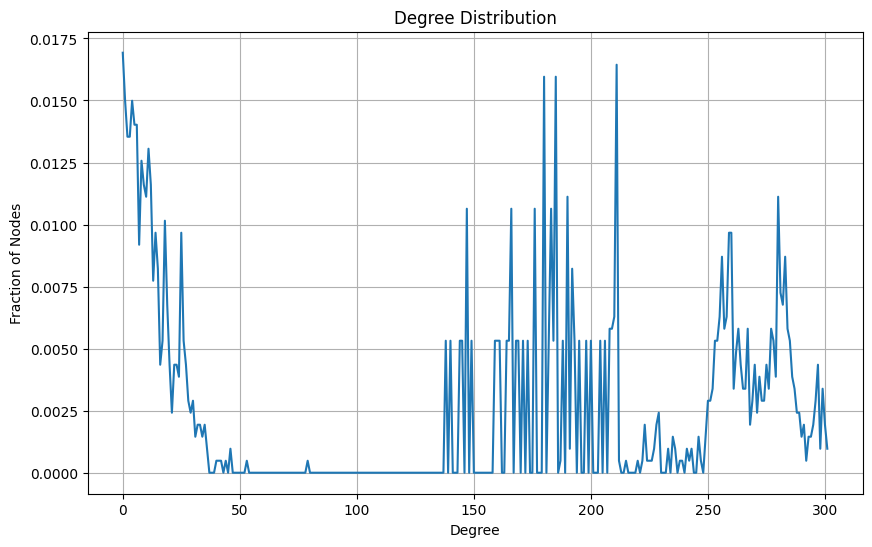

In [12]:
degree_counts = torch.bincount(degree_distribution[degree_distribution >= 0].int())
degree_fractions = degree_counts / degree_distribution.shape[0]

plt.figure(figsize=(10, 6))
plt.plot(degree_fractions.cpu())
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.grid(True)
plt.show()

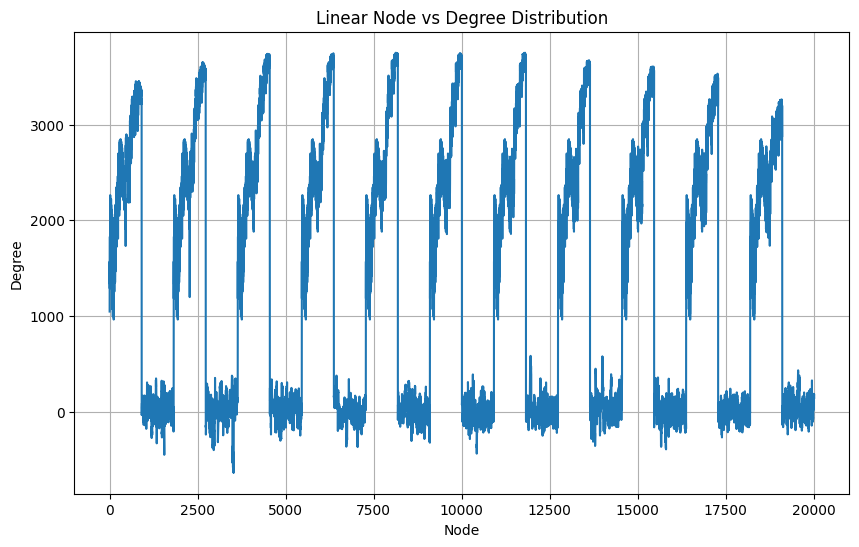

In [10]:
plt.figure(figsize=(10,6))
plt.plot(degree_distribution.cpu().detach().numpy())
plt.title('Linear Node vs Degree Distribution')
plt.xlabel('Node')
plt.ylabel('Degree')
plt.grid(True)
plt.show()